In [1]:
#@title Insatlling PyTorch

!pip install torch
!pip install torchvision

In [2]:
#@title Import dependencies

import torch
import torch.nn as nn
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [47]:
#@title Define hyperparameters

input_size = 784 # img_size = (28,28) ---> 28*28=784 in total
hidden_size = [100,100] # number of neurons at hidden layer
num_classes = 10 # number of output classes discrete range [0,9]
num_epochs = 10 # number of times which the entire dataset is passed throughout the model
batch_size = 100 # the size of input data took for one iteration
lr = 1e-3 # size of step

In [7]:
#@title Downloading MNIST data

train_data = dsets.MNIST(root = './data', train = True,
                        transform = transforms.ToTensor(), download = True)
test_data = dsets.MNIST(root = './data', train = False,
                       transform = transforms.ToTensor())
print("Size of the train dataset:",tuple(train_data.data.shape))
print("Size of the test dataset:",tuple(test_data.data.shape))

Size of the train dataset: (60000, 28, 28)
Size of the test dataset: (10000, 28, 28)


In [37]:
#@title Loading the data

train_loader = torch.utils.data.DataLoader(dataset = train_data,
                                             batch_size = batch_size,
                                             shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size,
                                      shuffle = False)

Image size: (28, 28)
Label of this image: 3


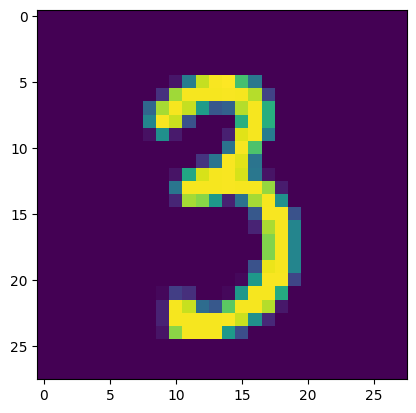

In [38]:
#@title Show the data

images = train_data.data
labels = train_data.targets
image_inx = 98
image = images[image_inx]
label = labels[image_inx]
print("Image size:",tuple(image.shape))
print("Label of this image:",label.numpy())
plt.imshow(image.numpy().squeeze())

In [39]:
#@title Define model class

class FCNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FCNN, self).__init__()

        layer_sizes = [input_size] + hidden_sizes + [output_size]
        layers = []

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())  # Using ReLU activation function

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [40]:
#@title Build the model

model = FCNN(input_size, hidden_size, num_classes)
if torch.cuda.is_available(): # GPU
  model.cuda()
  print("Using GPU (CUDA)")
else:
  print("Using CPU")


Using CPU


In [34]:
#@title Define loss function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Epoch [1/10], Step [100/600], Loss: 2.2887
Epoch [1/10], Step [200/600], Loss: 2.2635
Epoch [1/10], Step [300/600], Loss: 2.2884
Epoch [1/10], Step [400/600], Loss: 2.2736
Epoch [1/10], Step [500/600], Loss: 2.2904
Epoch [1/10], Step [600/600], Loss: 2.2793
Epoch [1/10], Train Loss: 2.2859, Train Acc: 10.91%, Val Loss: 2.2852, Val Acc: 11.13%
Epoch [2/10], Step [100/600], Loss: 2.2713
Epoch [2/10], Step [200/600], Loss: 2.2865
Epoch [2/10], Step [300/600], Loss: 2.2834
Epoch [2/10], Step [400/600], Loss: 2.2791
Epoch [2/10], Step [500/600], Loss: 2.2863
Epoch [2/10], Step [600/600], Loss: 2.2957
Epoch [2/10], Train Loss: 2.2859, Train Acc: 10.91%, Val Loss: 2.2852, Val Acc: 11.13%
Epoch [3/10], Step [100/600], Loss: 2.2756
Epoch [3/10], Step [200/600], Loss: 2.2772
Epoch [3/10], Step [300/600], Loss: 2.2810
Epoch [3/10], Step [400/600], Loss: 2.2863
Epoch [3/10], Step [500/600], Loss: 2.2707
Epoch [3/10], Step [600/600], Loss: 2.2872
Epoch [3/10], Train Loss: 2.2859, Train Acc: 10.91%,

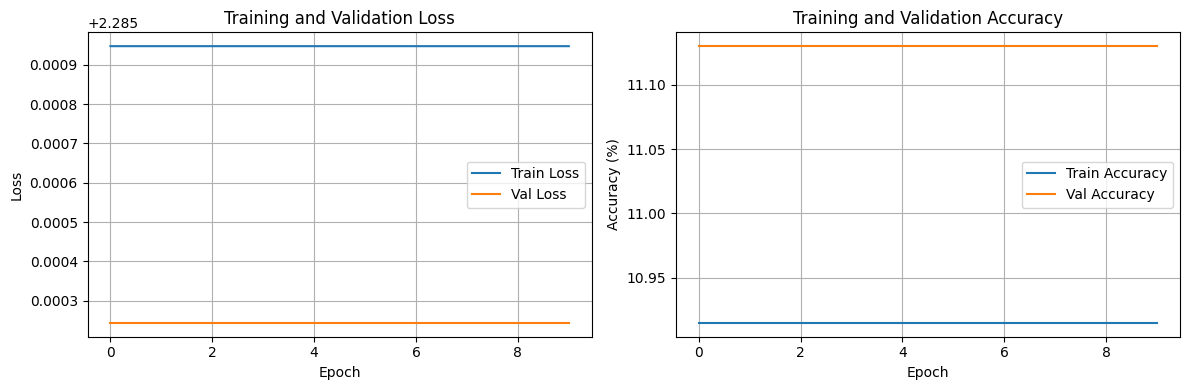

Final Test Accuracy: 11.13%


In [46]:
#@title Training the model
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (images, labels) in enumerate(train_loader):
        # Move to the device
        if torch.cuda.is_available():
            images = Variable(images.view(-1, 28*28)).cuda()
            labels = Variable(labels).cuda()
        else:
            images = Variable(images.view(-1, 28*28))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        if (i+1) % batch_size == 0:
            print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f'
                     %(epoch+1, num_epochs, i+1, len(train_data)//batch_size, loss.item()))

    # 计算训练集的平均loss和准确率
    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # 验证阶段
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images = Variable(images.view(-1, 28*28)).cuda()
                labels = Variable(labels).cuda()
            else:
                images = Variable(images.view(-1, 28*28))
                labels = Variable(labels)

            outputs = model(images)
            loss = loss_function(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # 计算验证集的平均loss和准确率
    val_loss = val_loss / len(test_loader)
    val_accuracy = 100 * correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

# 绘制loss曲线
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# 绘制accuracy曲线
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# 最终模型评估
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        if torch.cuda.is_available():
            images = images.view(-1, 28*28).cuda()
            labels = labels.cuda()
        else:
            images = images.view(-1, 28*28)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Final Test Accuracy: {100 * correct / total:.2f}%')

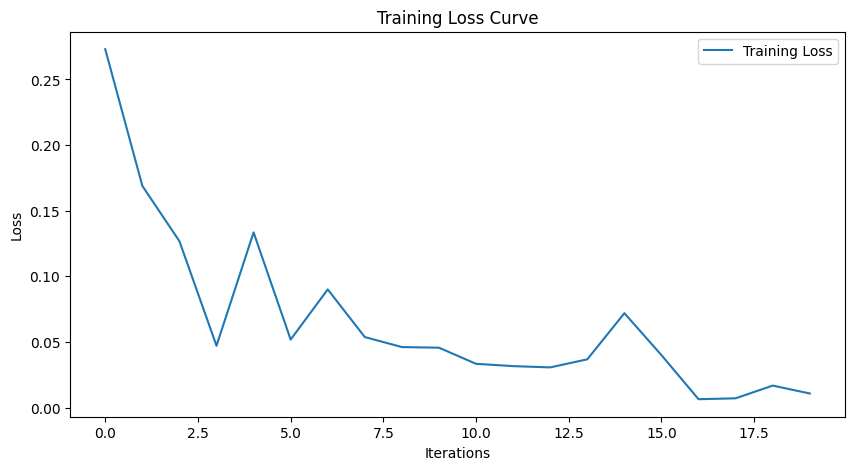

In [ ]:
# Plot the loss curve
plt.figure(figsize=(10, 5))
plt.plot(range(len(losses)), losses, label='Training Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

In [ ]:
#@title Save the model

torch.save(model.state_dict(), '/content/fcnn.pth')

In [ ]:
#@title Evaluating the accuracy of the model

from google.colab import files
# files.download('/content/fcnn.pth')
net = FCNN(input_size, hidden_size, num_classes)  # Instantiate your model class
net.load_state_dict(torch.load('/content/fcnn.pth'))
if torch.cuda.is_available():
  net.eval().cuda()  # Set the model to evaluation mode, GPU
else:
  net.eval()  # Set the model to evaluation mode, CPU
correct = 0
total = 0
for images,labels in test_loder:
  if torch.cuda.is_available(): # GPU
    images = Variable(images.view(-1,28*28)).cuda() # (28,28) ---> 28*28=784
    labels = labels.cuda()
  else: # CPU
    images = Variable(images.view(-1,28*28)) # (28,28) ---> 28*28=784
    labels = labels
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)
print('Accuracy of the net: %.3f %%' %((100*correct)/(total+1)))

<ipython-input-14-9eb8f82eba88>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('/content/fcnn.pth'))


Accuracy of the net: 97.730 %


Label of the image: 7
The prediction: [7]


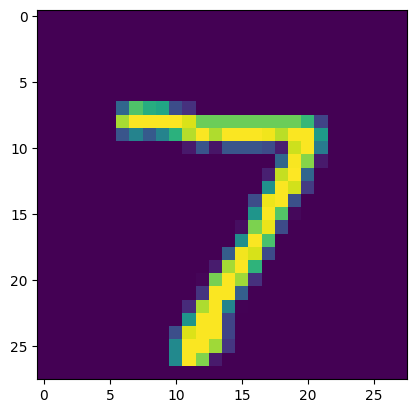

In [ ]:
#@title Test some examples in MNIST (Correct prediction: obvious)

images = test_data.data
labels = test_data.targets
image = images[0].to(torch.float32)
label = labels[0]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 6
The prediction: [6]


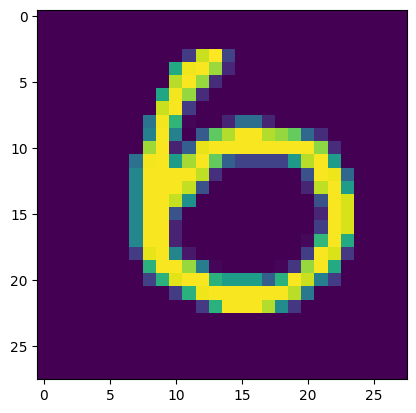

In [ ]:
#@title Test some examples in MNIST (Correct prediction: 6 or 0?)

images = test_data.data
labels = test_data.targets
image = images[259].to(torch.float32)
label = labels[259]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 6
The prediction: [0]


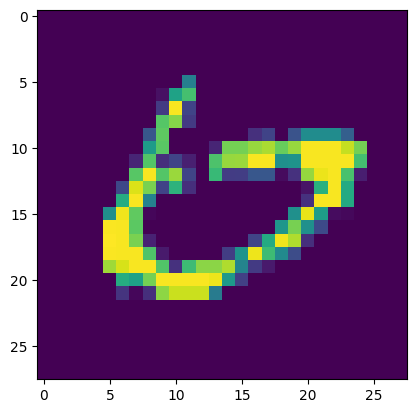

In [ ]:
#@title Test some examples in MNIST (Wrong prediction: 6 or 0?)

images = test_data.data
labels = test_data.targets
image = images[445].to(torch.float32)
label = labels[445]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 5
The prediction: [6]


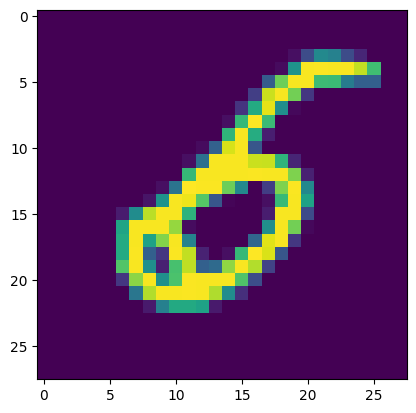

In [ ]:
#@title Test some examples in MNIST (Wrong prediction)

images = test_data.data
labels = test_data.targets
image = images[9729].to(torch.float32)
label = labels[9729]
plt.imshow(image.numpy().squeeze())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",label.numpy())
print("The prediction:",prediction.numpy())

Label of the image: 8
The prediction: [8]


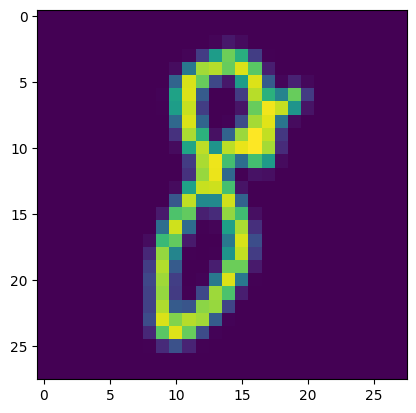

In [ ]:
#@title Test real handwritten digits (Correct prediction)

from PIL import Image
import torchvision.transforms as transforms

# Load the JPG image using PIL
image_jpg = Image.open('/content/test8.jpg')
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
image = 1-transform(image_jpg).squeeze()
# print(image_tensor.shape)
plt.imshow(image.numpy())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",8)
print("The prediction:",prediction.numpy())

Label of the image: 1
The prediction: [1]


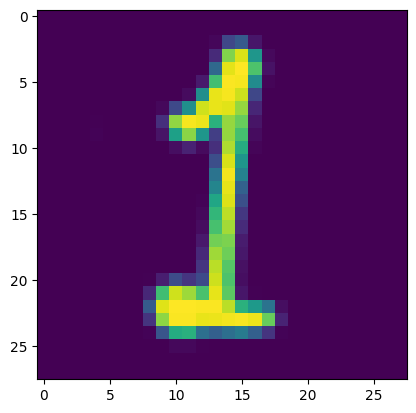

In [ ]:
# Load the JPG image using PIL
image_jpg = Image.open('/content/test1.jpg')
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
image = 1-transform(image_jpg).squeeze()
# print(image_tensor.shape)
plt.imshow(image.numpy())
net.cpu()
output = net(image.view(-1,28*28));
_, prediction = torch.max(output,1)
# print("Image size:",tuple(image.shape))
print("Label of the image:",1)
print("The prediction:",prediction.numpy())